## Import Semua Packages/Library yang Digunakan

In [ ]:
import os
import pathlib
import zipfile
import cv2
from collections import Counter
import shutil
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

## Data Preparation

### Data Loading

In [ ]:
zip_path = "/content/Alzheimer Dataset.zip"  # Path ke file ZIP
extract_path = "/content/"  # Direktori tujuan ekstraksi

# Pastikan direktori tujuan ada
os.makedirs(extract_path, exist_ok=True)

# Ekstrak file ZIP
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Ekstraksi selesai!")


Ekstraksi selesai!


### Data Preprocessing

#### Split Dataset

In [ ]:
TRAIN_DIR = "/content/data/train"
TEST_DIR = "/content/data/val"

In [ ]:
training_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
)


test_datagen = ImageDataGenerator(rescale=1. / 255)

In [ ]:
train_generator = training_datagen.flow_from_directory(
                    TRAIN_DIR,
                    target_size=(180, 180),
                    batch_size=128,
                    class_mode='categorical',
                    subset='training')

validation_generator = training_datagen.flow_from_directory(
                    TRAIN_DIR,
                    target_size=(180, 180),
                    batch_size=128,
                    class_mode='categorical',
                    subset='validation')

test_generator = test_datagen.flow_from_directory(
                    TEST_DIR,
                    batch_size=1,
                    target_size=(180,180),
                    class_mode='categorical',
                    shuffle=False)

Found 27188 images belonging to 4 classes.
Found 6796 images belonging to 4 classes.
Found 6400 images belonging to 4 classes.


### Membuat Callback

In [ ]:
class SaveBestModelCallback(tf.keras.callbacks.Callback):
    def __init__(self, save_dir='best_model', monitor='val_accuracy'):
        super(SaveBestModelCallback, self).__init__()
        self.save_dir = save_dir
        self.monitor = monitor
        self.best_acc = 0.0

        if not os.path.exists(self.save_dir):
            os.makedirs(self.save_dir)

    def on_epoch_end(self, epoch, logs=None):
        if logs is None:
            logs = {}
        current_acc = logs.get(self.monitor)

        if current_acc is not None and current_acc > self.best_acc:
            self.best_acc = current_acc
            model_path = os.path.join(self.save_dir, 'best_model.keras')
            self.model.save(model_path)
            print(f"\nBest model saved at epoch {epoch+1} with {self.monitor}: {current_acc:.4f}")


early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True, mode='max')

## Modelling

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(180, 180, 3)),
    tf.keras.layers.Conv2D(8, (3,3), activation='relu', strides=(1,1)),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=(1,1)),
    tf.keras.layers.Conv2D(16, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(4, activation='softmax')
])

# Lihat struktur model
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 178, 178, 8)         │             224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 177, 177, 8)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 175, 175, 16)        │           1,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 87, 87, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 85, 85, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 42, 42, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 56448)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │       3,612,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4)                   │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,619,028 (13.81 MB)

 Trainable params: 3,619,028 (13.81 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(loss ='categorical_crossentropy',
                  optimizer=tf.keras.optimizers.Adam(),
                  metrics=['accuracy'])

In [ ]:
# Training model
history = model.fit(train_generator,
                    epochs=100,
                    validation_data = validation_generator,
                    callbacks = [SaveBestModelCallback(), early_stopping])

Epoch 1/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step - accuracy: 0.3607 - loss: 1.2956
Best model saved at epoch 1 with val_accuracy: 0.6117
213/213 ━━━━━━━━━━━━━━━━━━━━ 63s 257ms/step - accuracy: 0.3610 - loss: 1.2950 - val_accuracy: 0.6117 - val_loss: 0.8468
Epoch 2/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - accuracy: 0.5333 - loss: 0.9386
Best model saved at epoch 2 with val_accuracy: 0.7029
213/213 ━━━━━━━━━━━━━━━━━━━━ 48s 223ms/step - accuracy: 0.5333 - loss: 0.9385 - val_accuracy: 0.7029 - val_loss: 0.7304
Epoch 3/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - accuracy: 0.5863 - loss: 0.8423
Best model saved at epoch 3 with val_accuracy: 0.7312
213/213 ━━━━━━━━━━━━━━━━━━━━ 48s 226ms/step - accuracy: 0.5863 - loss: 0.8423 - val_accuracy: 0.7312 - val_loss: 0.6289
Epoch 4/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - accuracy: 0.5995 - loss: 0.7895
Best model saved at epoch 4 with val_accuracy: 0.7531
213/213 ━━━━━━━━━━━━━━━━━━━━ 49s 230ms/step - accuracy: 0.5995 - los

## Evaluasi dan Visualisasi

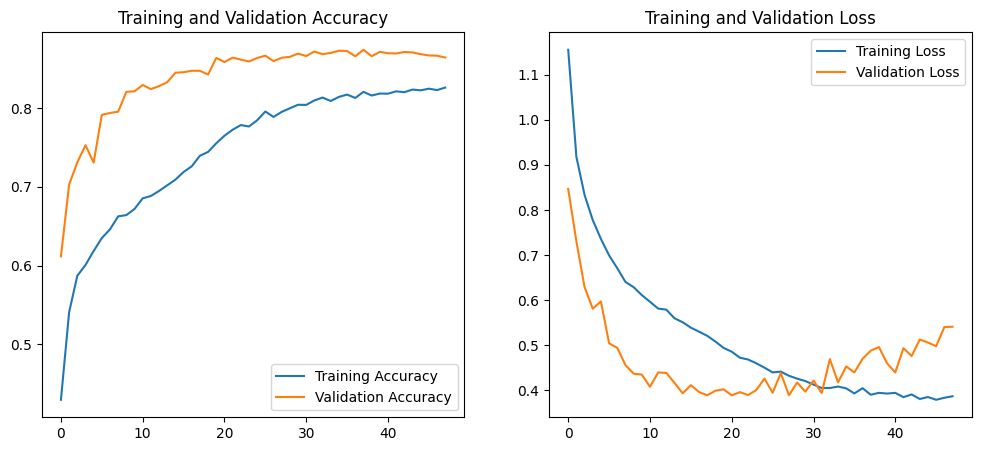

In [ ]:
# Fungsi untuk plot akurasi dan loss
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 5))

    # Plot Akurasi
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    plt.show()

# Panggil fungsi plot
plot_training_history(history)


In [ ]:
# Evaluasi model pada test set
test_loss, test_accuracy = model.evaluate(test_generator)

print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

6400/6400 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - accuracy: 0.9924 - loss: 0.0278
Test Accuracy: 98.06%
Test Loss: 0.0690


6400/6400 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step


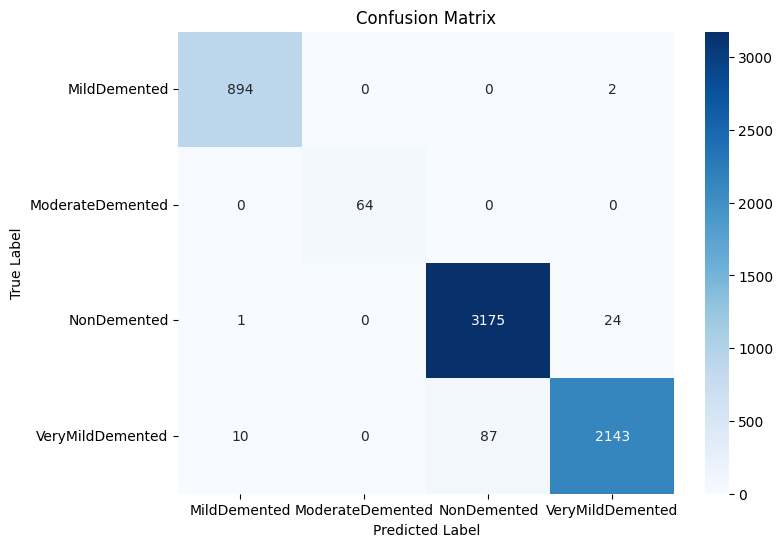

                  precision    recall  f1-score   support

    MildDemented       0.99      1.00      0.99       896
ModerateDemented       1.00      1.00      1.00        64
     NonDemented       0.97      0.99      0.98      3200
VeryMildDemented       0.99      0.96      0.97      2240

        accuracy                           0.98      6400
       macro avg       0.99      0.99      0.99      6400
    weighted avg       0.98      0.98      0.98      6400



In [ ]:
# Prediksi menggunakan model
y_pred_probs = model.predict(test_generator)  # Probabilitas prediksi
y_pred = np.argmax(y_pred_probs, axis=1)  # Ambil label prediksi

# Ambil label asli dari test_generator
y_true = test_generator.classes

# Buat confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Visualisasi confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Print Classification Report
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))


## Konversi Model

In [ ]:
save_path = 'saved_model/'
tf.saved_model.save(model, save_path)

In [ ]:
!zip -r /content/model_Alzheimer.zip /content/saved_model

  adding: content/saved_model/ (stored 0%)
  adding: content/saved_model/variables/ (stored 0%)
  adding: content/saved_model/variables/variables.index (deflated 62%)
  adding: content/saved_model/variables/variables.data-00000-of-00001 (deflated 37%)
  adding: content/saved_model/assets/ (stored 0%)
  adding: content/saved_model/fingerprint.pb (stored 0%)
  adding: content/saved_model/saved_model.pb (deflated 87%)
